<a href="https://colab.research.google.com/github/anamulislam0805/Big_Data_Lab/blob/main/Lab%20final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score, precision_score, recall_score, f1_score, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [37]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
#Hyper parameter
batch_size = 64
num_classes = 10
learning_rate = 0.001
num_epochs = 2

In [24]:
transform = transforms.Compose([transforms.Resize((32,32)),transforms.ToTensor()])

In [25]:
train_dataset = torchvision.datasets.KMNIST(root = './data',
                                           train = True,
                                           transform = transform,
                                           download = True)

In [26]:
test_dataset = torchvision.datasets.KMNIST(root = './data',
                                          train = False,
                                          transform = transform,
                                          download=True)

In [27]:
train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)


test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [28]:
for X, y in train_loader:
  print(X.shape)
  break

torch.Size([64, 1, 32, 32])


In [36]:
class LeNet(nn.Module):
      def __init__(self, num_classes=10):
          super(LeNet, self).__init__()
          self.conv_layers = nn.Sequential(
              nn.Conv2d(1, 6, kernel_size=5),  # Layer 1: Convolution
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # Pooling

              nn.Conv2d(6, 16, kernel_size=5),  # Layer 2: Convolution
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # Pooling

              nn.Conv2d(11, 26, kernel_size=5),  # Layer 3: Convolution
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # Pooling

              nn.Conv2d(16, 36, kernel_size=5),  # Layer 4: Convolution
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # Pooling

              nn.Conv2d(21, 46, kernel_size=5),  # Layer 5: Convolution
              nn.ReLU(),
              nn.AvgPool2d(kernel_size=2, stride=2),  # Pooling


          )

          self.fc_layers = nn.Sequential(
             nn.Linear(16 * 5 * 5, 120),
              nn.LeakyReLU(),
              nn.Linear(64, 84),
              nn.LeakyReLU(),
              nn.Linear(128, 84),
              nn.LeakyReLU(),
              nn.Linear(256, 84),
              nn.LeakyReLU(),
              nn.Linear(84, num_classes)
          )

      def forward(self, x):
          x = self.conv_layers(x)
          x = x.view(x.size(0), -1)
          x = self.fc_layers(x)
          return x

In [30]:
model = LeNet()
model.to(device)

LeNet(
  (conv_layers): Sequential(
    (0): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): AvgPool2d(kernel_size=2, stride=2, padding=0)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=400, out_features=120, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=84, out_features=10, bias=True)
  )
)

In [31]:
loss_fn = nn.CrossEntropyLoss() #mulitclass
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):

        outputs = model(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 400 == 0:
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
        		           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

Epoch [1/2], Step [400/938], Loss: 0.3249
Epoch [1/2], Step [800/938], Loss: 0.2256
Epoch [2/2], Step [400/938], Loss: 0.1416
Epoch [2/2], Step [800/938], Loss: 0.1382


In [33]:
true_labels = [] #for confusion matrix
predicted_labels = [] #for confusion matrix

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy= 100 * correct / total
    print('Accuracy of the network on the 10000 test images: {} %'.format(accuracy))
    top1_error = 100 - accuracy
    print('Top-1 Error: {} %'.format(top1_error))

Accuracy of the network on the 10000 test images: 89.07 %
Top-1 Error: 10.930000000000007 %


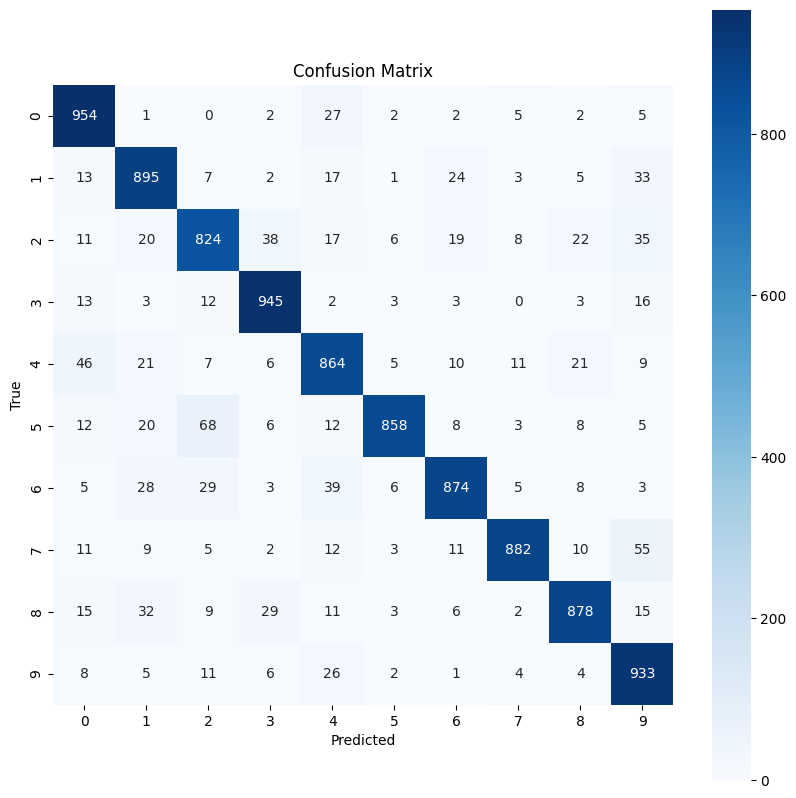

In [34]:
true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
confusion = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(num_classes, num_classes))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', square=True, xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()